In [68]:
import pandas as pd
import numpy as np

from pathlib import Path
import gdown

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, r2_score

### Get Data

In [2]:
PATH_TO_DATA = "C:\\Users\\Peteris\\Documents\\CV\\2025\\shiprojects\\hw_app\\data\\"
PATH_TO_DATA = "C:\\Users\\pich\\Documents\\CV\\2025\\shiprojects\\hw_app\\data\\"
file_name = "test-assignment-dataset.json"
data_url="https://drive.google.com/file/d/1Xx4ozrFDDmzDCuIyUTxjzj43eARpxW1o/view?usp=sharing"

In [3]:
def get_and_load_file(
        data_folder:str="../data/", filename=file_name,
        url:str=data_url)->pd.DataFrame:
    """
    Load JSON dataset into a DataFrame. 
    Download JSON dataset from a Google Drive URL, if not already present.
    :param data_folder: Path to the folder where the file should be stored or loaded from.
    :param filename: Name of the file to check, download, and load.
    :param url: Google Drive URL for downloading the file if it's not found locally.
    :return: A pandas DataFrame containing the data from the JSON file.
    """
    local_file_path = data_folder + filename
    if not Path(local_file_path).is_file():
        print(f"Source data file not present in {data_folder}, downloading file")
        gdown.download(url, local_file_path, fuzzy=True, quiet=False)  # quiet=True after testing
    df = pd.read_json(local_file_path)
    return df

df_source = get_and_load_file(data_folder=PATH_TO_DATA)  # change to default "../data/" after testing
df_source.sample(3)

,latitude,longitude,speedOverGround,draught,heading,courseOverGround,status,mainEngineMassFlowRate,mainEngineVolumeFlowRate,mainEngineDensity,...,windWavePeriod,windDirection,windSpeed,airTemperature,salinity,seaLevel,recommendedMassFlowRate,expectedSpeedOverGround,recommendedPower,expectedCarbonIntensityIndicator
92599,39.1178,-10.084800,9.9,5.2,184,180.3,0,156.527,0.182985,150.768,...,1.57,351.76,3.50,18.48,35.53,1.10,NaN,NaN,NaN,NaN
40118,43.4805,-8.249650,0.0,5.1,349,74.5,5,0.000,0.000000,831.050,...,1.41,198.86,1.08,19.66,35.35,1.14,NaN,NaN,NaN,NaN
2931,53.6253,-0.190653,0.0,6.0,36,40.9,5,0.000,0.000000,832.026,...,3.42,205.96,4.19,25.65,33.85,-0.53,NaN,NaN,NaN,NaN


### EDA

In [4]:
df_source.columns

Index(['latitude', 'longitude', 'speedOverGround', 'draught', 'heading',
       'courseOverGround', 'status', 'mainEngineMassFlowRate',
       'mainEngineVolumeFlowRate', 'mainEngineDensity',
       'mainEngineTemperature', 'mainEngineFuelConsumed',
       'auxEngineMassFlowRate', 'auxEngineVolumeFlowRate', 'auxEngineDensity',
       'auxEngineTemperature', 'shaftSpeed', 'shaftTorque', 'shaftPower',
       'specificFuelOilConsumption', 'timestamp', 'fuelEfficiency',
       'currentDirection', 'currentSpeed', 'gust', 'swellDirection',
       'swellHeight', 'swellPeriod', 'waveDirection', 'waveHeight',
       'wavePeriod', 'windWaveDirection', 'windWaveHeight', 'windWavePeriod',
       'windDirection', 'windSpeed', 'airTemperature', 'salinity', 'seaLevel',
       'recommendedMassFlowRate', 'expectedSpeedOverGround',
       'recommendedPower', 'expectedCarbonIntensityIndicator'],
      dtype='object')

In [5]:
print(df_source.shape)
df_source.info()

(326224, 43)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326224 entries, 0 to 326223
Data columns (total 43 columns):
 #   Column                            Non-Null Count   Dtype              
---  ------                            --------------   -----              
 0   latitude                          326222 non-null  float64            
 1   longitude                         326222 non-null  float64            
 2   speedOverGround                   326224 non-null  float64            
 3   draught                           326220 non-null  float64            
 4   heading                           326224 non-null  int64              
 5   courseOverGround                  326222 non-null  float64            
 6   status                            326224 non-null  int64              
 7   mainEngineMassFlowRate            326224 non-null  float64            
 8   mainEngineVolumeFlowRate          326224 non-null  float64            
 9   mainEngineDensity                 3

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
df_source.describe()

,latitude,longitude,speedOverGround,draught,heading,courseOverGround,status,mainEngineMassFlowRate,mainEngineVolumeFlowRate,mainEngineDensity,mainEngineTemperature,mainEngineFuelConsumed,auxEngineMassFlowRate,auxEngineVolumeFlowRate,auxEngineDensity,auxEngineTemperature,shaftSpeed,shaftTorque,shaftPower,specificFuelOilConsumption,fuelEfficiency,currentDirection,currentSpeed,gust,swellDirection,swellHeight,swellPeriod,waveDirection,waveHeight,wavePeriod,windWaveDirection,windWaveHeight,windWavePeriod,windDirection,windSpeed,airTemperature,salinity,seaLevel,recommendedMassFlowRate,expectedSpeedOverGround,recommendedPower,expectedCarbonIntensityIndicator
count,326222.000000,326222.000000,326224.000000,326220.000000,326224.000000,326222.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,3.262240e+05,3.262240e+05,170130.000000,308207.000000,308207.000000,326224.000000,317216.000000,317084.000000,317084.000000,308135.000000,319809.000000,305432.000000,316981.000000,316956.000000,317216.000000,326224.000000,326224.000000,326224.000000,326224.000000,326224.000000,42376.000000,42376.000000,4.237600e+04,41735.000000
mean,49.632092,2.978693,4.950242,5.139615,193.701527,184.906974,2.346624,101.245179,0.117942,815.007951,24.161276,1.687420,6.928908,0.007913,831.910785,29.055252,91.172805,25018.630128,4.726122e+05,1.345341e+04,24.023266,175.602391,0.213010,9.238503,231.826153,0.832728,5.962773,200.727807,1.248696,4.953513,195.791109,0.622706,2.573644,191.147175,6.184837,13.429885,32.111769,0.139154,208.732514,10.394949,1.002439e+06,13.708862
std,7.842426,11.030812,5.310358,0.852991,94.737099,101.332097,2.450708,107.507566,0.125246,180.324604,6.350480,1.791793,5.631603,0.006469,89.815379,4.816925,90.952806,26582.660106,5.129609e+05,1.096295e+06,49.499521,97.980663,0.188869,5.095318,94.955289,1.083965,2.736090,89.367433,1.353802,2.578808,89.104112,0.856438,1.822063,90.703968,3.610953,7.193249,5.866357,0.890680,34.060448,1.817699,1.919168e+05,3.732638
min,35.889400,-23.062100,0.000000,3.600000,0.000000,0.000000,0.000000,0.000000,0.000000,-102.695000,-36.085000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.480000,0.060000,0.010000,1.370000,0.130000,0.000000,1.270000,0.120000,0.000000,0.000000,0.000000,0.170000,-5.090000,8.500000,-3.650000,117.000000,2.714490,4.536688e+05,6.323664
25%,43.360600,-4.751288,0.000000,4.000000,119.000000,104.700000,0.000000,0.000000,0.000000,844.099000,19.763700,0.000000,0.000000,0.000000,833.019000,25.154087,0.230909,561.959000,1.137835e+01,0.000000e+00,16.982491,92.790000,0.090000,5.140000,168.610000,0.100000,3.970000,138.370000,0.390000,2.920000,133.280000,0.090000,1.450000,116.290000,3.350000,6.690000,30.380000,-0.280000,174.000000,9.030438,8.141896e+05,11.299184
50%,51.623500,3.744930,0.200000,5.600000,207.000000,191.400000,1.000000,0.223440,0.000000,859.116000,25.441300,0.003724,8.562600,0.009678,852.911500,29.616125,1.698130,1839.530000,2.460855e+02,1.509878e+02,19.791990,180.000000,0.150000,8.460000,263.920000,0.500000,5.690000,207.890000,0.810000,4.370000,203.150000,0.360000,2.230000,205.400000,5.330000,14.220000,34.920000,0.070000,200.000000,10.428973,9.676852e+05,12.926036
75%,54.436675,8.506670,10.600000,5.900000,271.000000,270.000000,5.000000,208.348250,0.242225,866.413000,27.714200,3.472471,10.602400,0.012155,863.605000,32.971000,182.396000,50966.000000,9.712270e+05,2.136662e+02,22.387983,259.750000,0.300000,12.870000,308.040000,1.060000,7.930000,276.440000,1.750000,5.990000,260.080000,0.790000,3.420000,255.000000,8.220000,19.260000,35.500000,0.550000,246.000000,11.423510,1.190503e+06,15.216035
max,66.328200,32.230000,17.300000,6.000000,359.000000,359.900000,5.000000,572.696000,0.680159,880.345000,149.950000,9.544933,28.019000,0.046928,875.904500,46.816250,185.733000,94223.400000,1.796530e+06,2.832681e+08,3176.

In [7]:
pd.reset_option('all')

C:\Users\pich\AppData\Local\Temp\ipykernel_7332\2786130087.py:1: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option('all')
C:\Users\pich\AppData\Local\Temp\ipykernel_7332\2786130087.py:1: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')


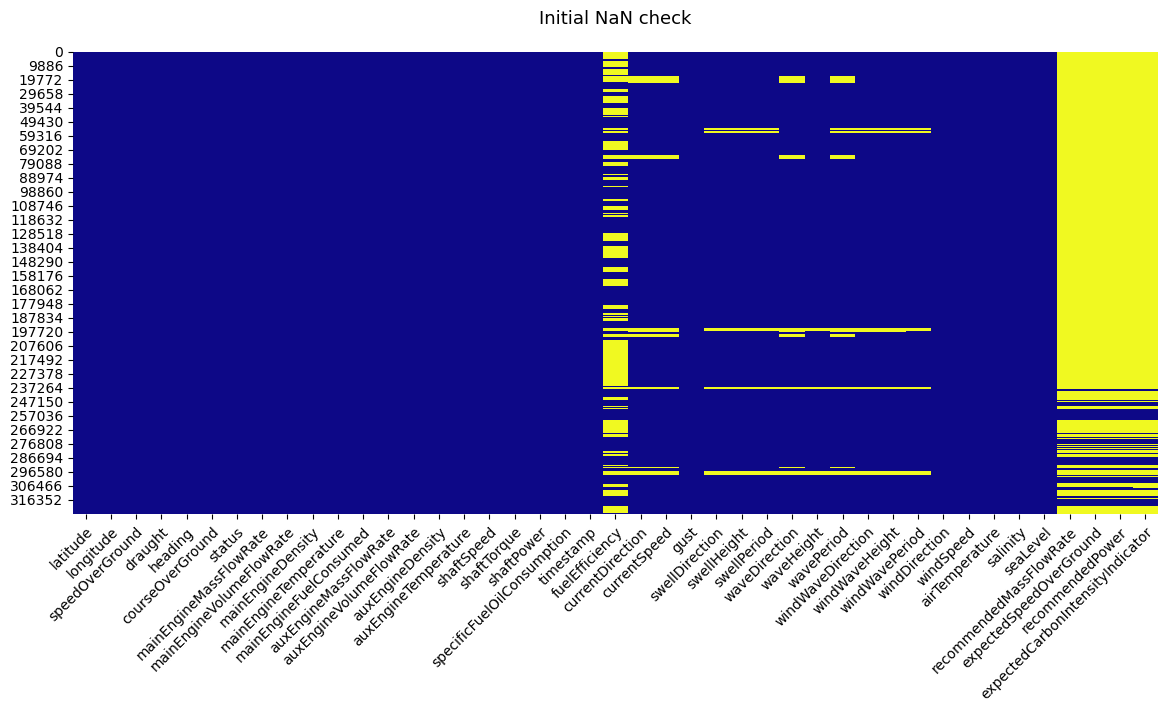

In [8]:
plt.figure(figsize=(df_source.shape[1] // 3, 6))
sns.heatmap(df_source.isnull(), cmap='plasma', cbar=False)
plt.title("Initial NaN check\n", 
          fontsize=13)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

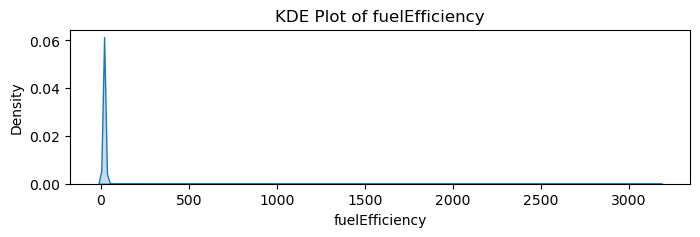

In [9]:
plt.figure(figsize=[8, 2])
sns.kdeplot(data=df_source['fuelEfficiency'].dropna(), fill=True)
plt.title('KDE Plot of fuelEfficiency')
plt.xlabel('fuelEfficiency')
plt.ylabel('Density')
plt.show()

In [10]:
df_source['fuelEfficiency'].value_counts(dropna=True, ascending=False, normalize=True).head(5)

fuelEfficiency
0.00     0.065826
20.55    0.000035
18.66    0.000029
19.74    0.000024
16.52    0.000024
Name: proportion, dtype: float64

In [11]:
nan_rows = df_source[df_source.loc[:, 'currentDirection':'seaLevel'].isnull().any(axis=1)].index  # rows, where specified columns contain NaNs
print(f"proportion of rows containing nan values in selected rows ('currentDirection':'seaLevel') \
against entire dataset:\n{round(len(nan_rows)/df_source.shape[0]*100, 1)}%")

proportion of rows containing nan values in selected rows ('currentDirection':'seaLevel') against entire dataset:
6.4%


In [12]:
print(f"Correlation between sparsely populated 'expected' and 'registered' speeds over ground:\
    {df_source["speedOverGround"].corr(df_source["expectedSpeedOverGround"])}")
print(f"Correlation between sparsely populated 'recommended' and 'registered' mass flow rates:\
    {df_source["mainEngineMassFlowRate"].corr(df_source["recommendedMassFlowRate"])}")
print(f"Correlation between sparsely populated 'recommended' and 'registered' power:\
    {df_source["shaftPower"].corr(df_source["recommendedPower"])}")


Correlation between sparsely populated 'expected' and 'registered' speeds over ground:    0.30263690090074735
Correlation between sparsely populated 'recommended' and 'registered' mass flow rates:    0.5643054263353686
Correlation between sparsely populated 'recommended' and 'registered' power:    0.6290641912284795


- #### With only ~6% of rows containing missing values for weather data, I will delete them in training task:
    - To decide on best imputation strategy for missing environmental data (weather, sea conditions) domain expert is needed on:
        - whether mean/mode imputation is sufficient
        - Does dataset structure (eg row sequence, timestamp) has sufficient for k-neighbors imputation
        - does other columns are sufficient predictors to use regression imputation
- #### Drop sparsely populated 'expected' and 'recommended' engine data features:
    - Correlations between 'expected'/'recommended' features range wro weak to strong.
    - Thus some of them could be useful for model training.
    - However, cleaning up their missing values is not feasible unless these features have particular importance according to domain expert oppinion (missing in this exercise).
- #### Replace 'fuelEfficiency' NaNs with zeroes as it is most popular value among "good" entries for the feature anyway

### Data Preprocessing

In [13]:
def clean_data(data:pd.DataFrame, nan_col_start='currentDirection',
               nan_col_end= 'seaLevel', cols_to_dorp = [
                   "recommendedMassFlowRate",
                   "expectedSpeedOverGround",
                   "recommendedPower",
                   "expectedCarbonIntensityIndicator",
                   ],
               nan_to_zero_columns:list=["fuelEfficiency"],
               )->pd.DataFrame:
    """
    Clean and preprocess the dataset for modeling:
    1) Create a deep copy of the input dataset to preserve the original data.
    2) Identify and drop rows with any NaN values between specified columns (inclusive).
    3) Remove predefined columns unrelated to model input.
    4) Fill missing values in the specified columns with 0.
    5) Drop columns that contain single unique value (not useful for ML algorithm)

    :param data: Input DataFrame to be cleaned.
    :param nan_col_start: Column name where NaN checking should begin (inclusive).
    :param nan_col_end: Column name where NaN checking should end (inclusive).
    :param nan_to_zero_columns: specify al list of columns where NaN values will be replaced by 0.
    :return: A cleaned DataFrame with rows and columns filtered and missing data handled.
    """
    df_new = data.copy(deep=True)

    nan_rows = df_new[df_new.loc[:, nan_col_start:nan_col_end].isnull().any(axis=1)].index
    df_new = df_new.drop(index=nan_rows)
    df_new = df_new.drop(columns=cols_to_dorp)
    if nan_to_zero_columns:
        for column in nan_to_zero_columns:
            df_new[column] = df_new[column].fillna(0)
    df_new = df_new.drop(columns=[col for col in df_new.columns 
                                  if df_new[col].nunique(dropna=False) == 1])

    return df_new

df_clean = clean_data(df_source)
df_clean.shape

(305432, 39)

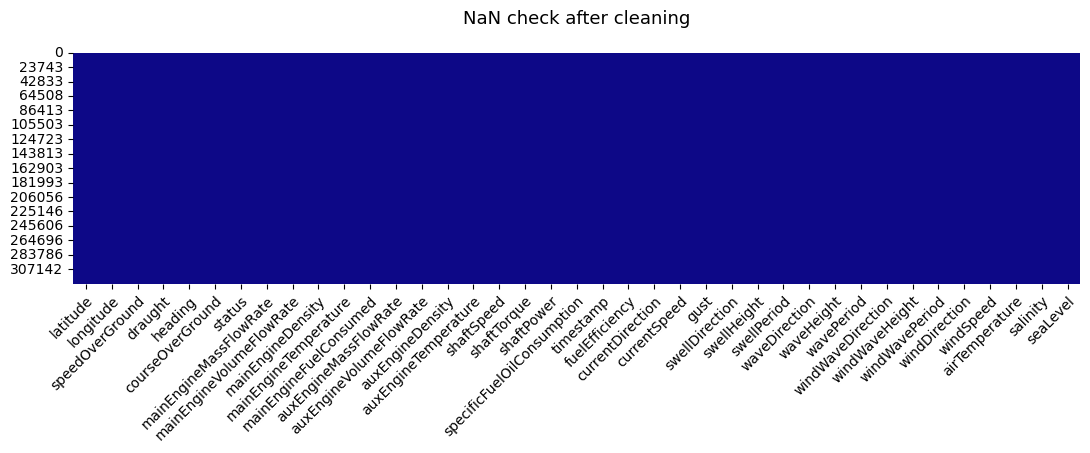

In [14]:
plt.figure(figsize=(df_clean.shape[1] // 3, 3))
sns.heatmap(df_clean.isnull(), cmap='plasma', cbar=False)
plt.title("NaN check after cleaning\n", 
          fontsize=13)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

### Feature Selection 

In [15]:
f"Dates in 'timestamp' feature range from {min(df_clean["timestamp"])} to {max(df_clean["timestamp"])}."

"Dates in 'timestamp' feature range from 2024-07-26 10:24:00+00:00 to 2025-03-12 23:59:00+00:00."

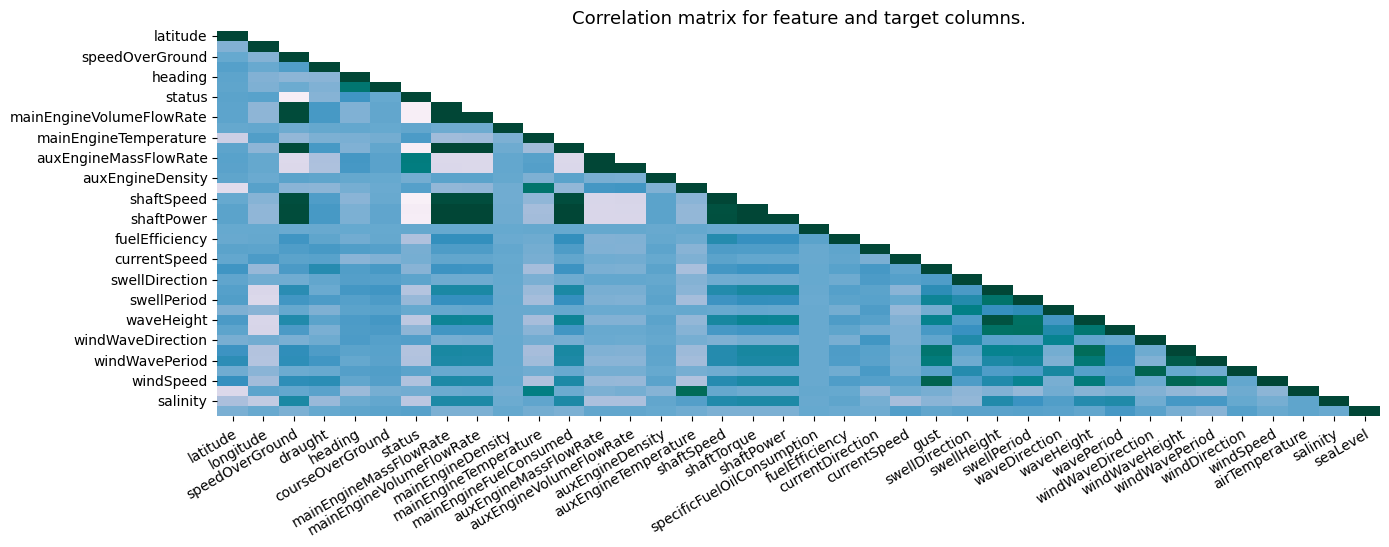

In [16]:
def compute_correlations_matrix(data=df_clean):
    """
    Compute and display a heatmap of the correlation matrix for numerical features.    
    :param dataset: pandas DataFrame containing the input data.
    :return: pandas DataFrame of the correlation matrix.
    """
    plt.figure(figsize=(15, 5))
    correlation_matrix = data.select_dtypes(include='number').corr()
    triangular_matrix = np.triu(correlation_matrix, k=1)

    sns.heatmap(
      data=correlation_matrix,
      center=0,
      cmap= 'PuBuGn',
      cbar=False,
      annot=False,
      mask=triangular_matrix
    )
    plt.xticks(rotation=30,ha='right', rotation_mode="anchor")
    plt.title("Correlation matrix for feature and target columns.", fontsize=13);
    return correlation_matrix


correlations = compute_correlations_matrix(df_clean)

In [17]:
def top_correlations(data:pd.DataFrame=df_clean, corr_threshold:float=0.95)->pd.Series:
    """
    Identify and return highly correlated feature pairs above a specified threshold.
    :param data: pandas DataFrame containing the input dataset. Defaults to df_clean.
    :param corr_threshold: Correlation threshold to filter feature pairs. Default is 0.95.
    :return: A pandas Series with multi-index (feature pairs) and correlation values.
    """
    corrs = data.select_dtypes(include='number').corr()
    corrs = corrs.unstack().sort_values(ascending=False)
    corrs = corrs[(corrs.abs() > corr_threshold) & 
                        (corrs.index.get_level_values(0) != corrs.index.get_level_values(1))]
    corrs = corrs.drop_duplicates()
    return corrs

sorted_corr = top_correlations()

print(f"Features with correlation exceeding 0.95:")
sorted_corr

Features with correlation exceeding 0.95:


mainEngineFuelConsumed    mainEngineMassFlowRate      1.000000
shaftTorque               shaftPower                  0.999863
mainEngineVolumeFlowRate  mainEngineFuelConsumed      0.999707
mainEngineMassFlowRate    mainEngineVolumeFlowRate    0.999707
auxEngineMassFlowRate     auxEngineVolumeFlowRate     0.998790
shaftPower                mainEngineMassFlowRate      0.997480
                          mainEngineFuelConsumed      0.997480
mainEngineVolumeFlowRate  shaftPower                  0.997222
mainEngineMassFlowRate    shaftTorque                 0.996975
mainEngineFuelConsumed    shaftTorque                 0.996975
shaftTorque               mainEngineVolumeFlowRate    0.996593
mainEngineVolumeFlowRate  speedOverGround             0.961140
mainEngineMassFlowRate    speedOverGround             0.960426
speedOverGround           mainEngineFuelConsumed      0.960426
                          shaftPower                  0.953782
                          shaftTorque                 0

### Conclusion: multicollinearity detected, conduct feature selection:
- #### 	Drop/Combine/Regularize if linear (including ridge or lasso) or even SVM regressions used
- #### feature still selection recommended for tree based or Gradient Boosting models
- #### Will drop drop potentially derived or redundant features:
    - #### `mainEngineFuelConsumed`: Possibly a computed value from mass flow
    - #### `shaftTorque`: derived from `mainEngineMassFlowRate` and target `shaftPower`
    - #### 	`auxEngineVolumeFlowRate` and `mainEngineVolumeFlowRate`: Volume flow might be calculated from mass flow
    - #### `mainEngineFuelConsumed`: same as `mainEngineMassFlowRate` measures fuel movement

In [ ]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    Remove selected features (columns) from the input DataFrame.
    Inherits from scikit-learn's BaseEstimator and TransformerMixin 
            for scikit-learn pipeline compatibility.
     Used to simplify datasets by excluding specified columns during preprocessing.
    :param data: pandas DataFrame to process. Defaults to df_clean.
    :param features_to_drop: List of column names to drop.
    """

    def __init__(self, features_to_drop:list=None):
        """"
        Initialize with the provided data and feature configurations.
        Store the list of features to drop for later use in transformation.
        """
        self.features_to_drop = features_to_drop


    def fit(self, X, y=None):
        """
        Fit method for compatibility with scikit-learn pipelines.
        Does not perform any fitting operation.
        """
        return self
    

    def transform(self, X: pd.DataFrame, feature_to_drop:list=None)->pd.DataFrame:
        """
        Remove specified features (columns) from the input DataFrame.
        Uses instance-level 'features_to_drop' unless an override list is provided.
        :param X: input data.
        :param features_to_drop: List of column names to drop.
        :return: A new pandas DataFrame with the specified features removed.
        """
        df_new = X.copy(deep=True)
        features = feature_to_drop or self.features_to_drop
        if features:
            df_new.drop(columns=features, inplace=True)
            
        return df_new

In [ ]:
collinear_features=[
    "mainEngineFuelConsumed",
    "shaftTorque", 
    "auxEngineVolumeFlowRate", 
    "mainEngineVolumeFlowRate",
    ]

feature_selector = FeatureSelector(features_to_drop=collinear_features)

df_feat_sel = feature_selector.transform(X=df_clean)
df_feat_sel.shape

,latitude,longitude,speedOverGround,draught,heading,courseOverGround,status,mainEngineMassFlowRate,mainEngineDensity,mainEngineTemperature,...,waveHeight,wavePeriod,windWaveDirection,windWaveHeight,windWavePeriod,windDirection,windSpeed,airTemperature,salinity,seaLevel
191655,55.7177,6.57823,9.6,5.4,212,212.3,0,210.849,863.755,17.2149,...,1.74,5.52,97.01,1.11,3.96,82.0,9.3,7.0,34.45,-0.14


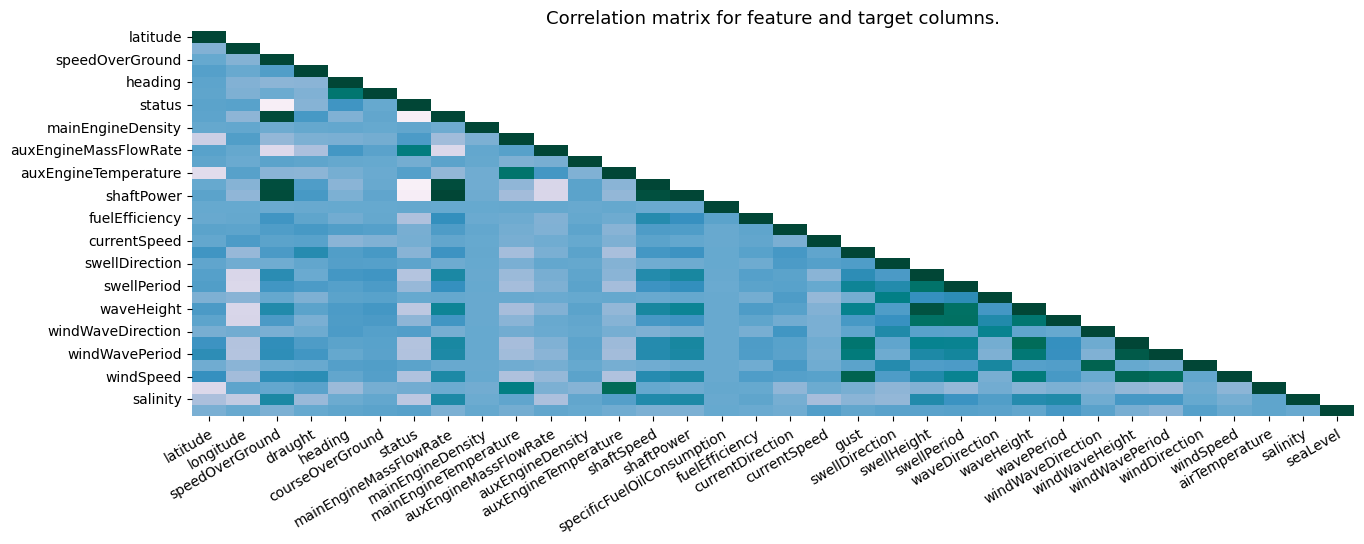

In [20]:
correlations = compute_correlations_matrix(df_feat_sel)

In [21]:
# Remove after testing
correlations_threshold = 0.95
sorted_corr_f = top_correlations(data=df_feat_sel, corr_threshold=correlations_threshold)

print(f"Features with correlation exceeding {correlations_threshold}:")
sorted_corr_f

Features with correlation exceeding 0.95:


shaftPower       mainEngineMassFlowRate    0.997480
speedOverGround  mainEngineMassFlowRate    0.960426
shaftPower       speedOverGround           0.953782
dtype: float64

### Feature Engineering

In [ ]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Engineer features: angular, force interaction and time.
    Inherits from scikit-learn's BaseEstimator and TransformerMixin 
            for scikit-learn pipeline compatibility.
    :param angular_features: List of angle-based feature column names (in degrees).
    :param env_force_features: List of (angle feature, force feature) pairs for decomposing forces.
    :param base_angle_feats: Reference angle column name (default, 'heading').
    :param base_time_feats: Column name for timestamp (default, 'timestamp').
    :param drop_original_features: Flag to optionally remove original features at 
                                    class level with 'transform()' method.
    """


    def __init__(self,
                 angular_features: list[str] = None,
                 env_force_features: list[tuple] = None,
                 base_angle_feats: str = "heading",
                 base_time_feats: str = "timestamp",
                 drop_original_features: bool = False
                 ):
        """
        Initialize with the provided data and feature configurations.
        Store configuration parameters for use in transformations.
        """
        self.angular_features = angular_features or []
        self.env_force_features = env_force_features or []
        self.base_angle_feat = base_angle_feats
        self.base_time_feat = base_time_feats
        self.drop_original_features = drop_original_features


    def fit(self, X, y=None):
        """
        Fit method for compatibility with scikit-learn pipelines.
        Does not perform any fitting operation.
        """
        return self
    

    @staticmethod
    def compute_relative_angle(angle1, angle2):
        """
        Compute absolute minimal angle difference between two angles (in degrees).
        :param angle1: First angle or Series of angles.
        :param angle2: Second angle or Series of angles.
        :return: Absolute minimal angular difference in degrees.
        """
        return np.abs(((angle1 - angle2 + 180) % 360) - 180)
    

    @staticmethod
    def drop_columns(data:pd.DataFrame, drop_list:list[str]):
        """
        Drop specified columns from the DataFrame.
        Check for presence of 'drop_list' features in DataFrame.
        :param data: DataFrame to modify.
        :param drop_list: List of column names to drop.
        :return: Modified DataFrame with columns removed.
        """
        data.drop(
            columns=[col for col in drop_list if col in data.columns],
            errors='ignore',
            inplace=True
            )
        
        return data


    def transform_angles(self,
                        X: pd.DataFrame,
                        angular_feature: list[str] = None,
                        drop_source_feature: bool = False) -> pd.DataFrame:
        """
        Compute relative angles between angular features and base_angle_feat.
        This feature provides if various external forces (current, wind, etc) facilitate 
            or counteract ship's course.
        If not specified otherwise, use parameters defined at 'FeatureEngineer' initialization.
        Check for duplicated columns and drop if any are created via multiple method calls.
        Optionally drop original columns.
        :param X: input data.
        :param angular_feature: List of angle-based feature column names (in degrees).
        :param drop_source_feature: Flag to drop original angle columns (default, False).
        :return: DataFrame with added relative angle features.
        """
        df_angle = X.copy(deep=True)
        features = angular_feature or self.angular_features

        for angle_feature in features:
            if angle_feature in df_angle.columns\
                and self.base_angle_feat in df_angle.columns:
                angle_to_heading = self.compute_relative_angle(
                    df_angle[angle_feature], df_angle[self.base_angle_feat])

                df_angle.insert(loc=df_angle.columns.get_loc(angle_feature) + 1,
                                column=angle_feature + '_rel_head',
                                value=angle_to_heading,
                                allow_duplicates=True)
                
        df_angle = df_angle.loc[:, ~df_angle.columns.duplicated()]  
        if drop_source_feature:
            df_angle = self.drop_columns(data=df_angle, drop_list=features+[self.base_angle_feat])
   
        return df_angle


    def transform_force_components(self,
                                   X: pd.DataFrame,
                                   env_force_feature: list[tuple] = None,
                                   drop_source_feature: bool = False) -> pd.DataFrame:
        """
        Add force features based on relative angle to base_angle_feat.
        This feature provides index for external forces (current, wind, etc) speed and angle
             counteracting ship's course. Higher index means stronger tail/cross components.
        If not specified otherwise, use parameters defined at 'FeatureEngineer' initialization.
        Check for duplicated columns and drop if any are created via multiple method calls.
        Optionally drop original columns.
        :param X: input data.
        :param env_force_feature: List of (angle_col, force_col) pairs for decomposing forces.
        :param drop_source_feature: Flag to drop original force columns (default, False).
        :return: DataFrame with new force features.
        """
        df_force = X.copy(deep=True)
        features = env_force_feature or self.env_force_features

        for angle_col, force_col in features:
            if angle_col in df_force.columns\
            and force_col in df_force.columns\
            and self.base_angle_feat in df_force.columns:
                rel_angle_rad = np.radians(
                    self.compute_relative_angle(
                        df_force[angle_col], df_force[self.base_angle_feat]))
                idx_force = df_force.columns.get_loc(force_col)

                df_force.insert(loc=idx_force + 1,
                                column=force_col + "_head",
                                value=df_force[force_col] * np.cos(rel_angle_rad),
                                allow_duplicates=True)

                # Insert cross-wind/current component
                df_force.insert(loc=idx_force + 1,
                                column=force_col + "_cross",
                                value=df_force[force_col] * np.sin(rel_angle_rad),
                                allow_duplicates=True)
            
                if drop_source_feature:
                    df_force = self.drop_columns(data=df_force, drop_list=[angle_col, force_col])
            
        df_force = df_force.loc[:, ~df_force.columns.duplicated()]
                
        return df_force
    

    def eng_direction_features(self,
                               X: pd.DataFrame, 
                                angular_feature: list[str] = None,
                                drop_source_feature: bool=False
                                )->pd.DataFrame:
        """
        Engineer sine and cosine components of directional features to preserve circularity.
        New sine and cosine features address issue arising from circularity of angle features
                     - e.g. that after 360 comes 0.
        If not specified otherwise, use parameters defined at 'FeatureEngineer' initialization.
        Check for duplicated columns and drop if any are created via multiple method calls.
        Optionally drop original columns.
        :param X: input data.
        :param angular_feature: List of directional feature columns (in degrees).
        :param drop_source_feature: Flag to drop original direction columns (default, False).
        :return: DataFrame with sine and cosine of directional features.
        """
        df_direction = X.copy(deep=True)
        features = angular_feature or self.angular_features

        for angle_feature in features:
            if angle_feature in df_direction.columns\
                and self.base_angle_feat in df_direction.columns:
                orig_feat_index = df_direction.columns.get_loc(angle_feature)
                df_direction.insert(loc=orig_feat_index+1,
                                    column=angle_feature+'_sin',
                                    value=np.sin(2 * np.pi * df_direction[angle_feature] / 360),
                                    # value=np.sin(np.radians(df_direction[feature])),
                                    allow_duplicates=True)
                df_direction.insert(loc=orig_feat_index+1,
                                    column=angle_feature+'_cos',
                                    value=np.cos(2 * np.pi * df_direction[angle_feature] / 360),
                                    # value=np.cos(np.radians(df_direction[feature])),
                                    allow_duplicates=True)

        if drop_source_feature:
            df_direction = self.drop_columns(data=df_direction, drop_list=features)
        df_direction = df_direction.loc[:, ~df_direction.columns.duplicated()]

        return df_direction
    

    def eng_circular_time_feats(self,
                                X: pd.DataFrame,
                                base_time_feat: str = None,
                                drop_source_feature: bool=False
                                ):
        """
        Create hour and month features from timestamp. 
        Both potentially indicate daily or seasonal weather patterns 
                    affecting ship's speed and engine workloads.
        Calculate sines and cosines to preserve circularity - e.g. that after 23 or 12 comes 0/1.
        If not specified otherwise, use parameters defined at 'FeatureEngineer' initialization.
        Assumes datetime data type for timestamp column.
        Check for duplicated columns and drop if any are created via multiple method calls.
        Optionally drop original columns.
        :param X: input data.
        :param base_time_feat: Column name containing time information (default, None).
        :param drop_source_feature: Flag to drop original timestamp columns (default, False).
        :return: DataFrame with sine and cosine components of the hour feature.
        """
        df_time = X.copy(deep=True)
        time_feature = base_time_feat or self.base_time_feat
        if time_feature in df_time.columns and pd.api.types.is_datetime64_any_dtype(df_time[time_feature]):
            idx_time = df_time.columns.get_loc(time_feature)
            new_time_features = [("hours", df_time[time_feature].dt.hour, 24),
                                 ("months", df_time[time_feature].dt.month, 12)]

            for name, values, circular_divisor in new_time_features:
                df_time.insert(loc=idx_time+1,
                                    column=name + "_sin",
                                    value=np.sin(2 * np.pi * values / circular_divisor),
                                    allow_duplicates=True)
                df_time.insert(loc=idx_time+1,
                                    column=name + "_cos",
                                    value=np.cos(2 * np.pi * values / circular_divisor),
                                    allow_duplicates=True)
            if drop_source_feature:
                df_time = self.drop_columns(df_time, [time_feature])

        return df_time


    def transform(self, X:pd.DataFrame) -> pd.DataFrame:
        """
        Apply transformations to angles, forces, directions, and power-to-speed ratio.
        Calls all 'FeatureEngineer' feature engineering steps sequentially and removes duplicates.
        Uses 'FeatureEngineer' instance-level 'drop_original_features' flag to remove original features.
        :param X: input data.
        :return: Transformed DataFrame with engineered features.
        """
        df = X.copy(deep=True)
        df = self.transform_angles(X=df)
        df = self.transform_force_components(X=df, drop_source_feature=self.drop_original_features)
        df = self.eng_direction_features(X=df, drop_source_feature=self.drop_original_features)
        df = self.eng_circular_time_feats(X=df, drop_source_feature=self.drop_original_features)
        if self.drop_original_features is not False:
            df = self.drop_columns(data=df, drop_list=[self.base_angle_feat, self.base_time_feat])
        df = df.loc[:, ~df.columns.duplicated()]

        return df

In [41]:
engineer = FeatureEngineer(
    angular_features=[
        "windDirection",
        "currentDirection",
        "waveDirection",
        "swellDirection",
        "windWaveDirection"
        ],
    env_force_features=[
        ("windDirection","windSpeed"),
        ("currentDirection", "currentSpeed")
        ],
    drop_original_features=True,
)
df_feat_eng = engineer.transform(X=df_feat_sel)
df_feat_eng.columns

Index(['latitude', 'longitude', 'speedOverGround', 'draught',
       'courseOverGround', 'status', 'mainEngineMassFlowRate',
       'mainEngineDensity', 'mainEngineTemperature', 'auxEngineMassFlowRate',
       'auxEngineDensity', 'auxEngineTemperature', 'shaftSpeed', 'shaftPower',
       'specificFuelOilConsumption', 'months_cos', 'months_sin', 'hours_cos',
       'hours_sin', 'fuelEfficiency', 'currentDirection_rel_head',
       'currentSpeed_cross', 'currentSpeed_head', 'gust', 'swellDirection_cos',
       'swellDirection_sin', 'swellDirection_rel_head', 'swellHeight',
       'swellPeriod', 'waveDirection_cos', 'waveDirection_sin',
       'waveDirection_rel_head', 'waveHeight', 'wavePeriod',
       'windWaveDirection_cos', 'windWaveDirection_sin',
       'windWaveDirection_rel_head', 'windWaveHeight', 'windWavePeriod',
       'windDirection_rel_head', 'windSpeed_cross', 'windSpeed_head',
       'airTemperature', 'salinity', 'seaLevel'],
      dtype='object')

In [55]:
df_feat_eng.sample(1)

,latitude,longitude,speedOverGround,draught,courseOverGround,status,mainEngineMassFlowRate,mainEngineDensity,mainEngineTemperature,auxEngineMassFlowRate,...,windWaveDirection_sin,windWaveDirection_rel_head,windWaveHeight,windWavePeriod,windDirection_rel_head,windSpeed_cross,windSpeed_head,airTemperature,salinity,seaLevel
276946,55.0576,-16.2199,7.7,5.7,322.7,0,253.624,866.233,16.8473,12.2726,...,-0.846286,79.19,3.67,7.45,86.33,14.091044,0.903818,9.0,35.51,0.56


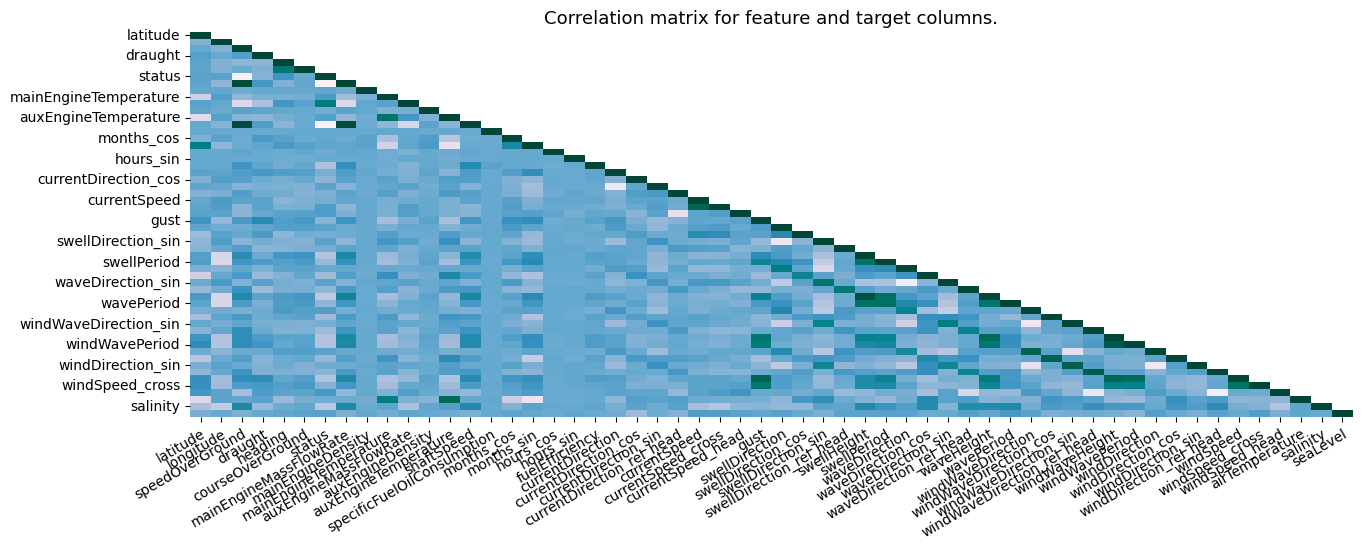

In [118]:
correlations = compute_correlations_matrix(df_feat_eng)

In [ ]:
correlations_threshold = 0.90
sorted_corr_f = top_correlations(data=df_feat_eng, corr_threshold=correlations_threshold)

print(f"Features with correlation exceeding {correlations_threshold}:")
sorted_corr_f

Features with correlation exceeding 0.9:


shaftPower              mainEngineMassFlowRate    0.997480
speedOverGround         mainEngineMassFlowRate    0.960426
shaftPower              speedOverGround           0.953782
mainEngineMassFlowRate  shaftSpeed                0.945632
speedOverGround         shaftSpeed                0.937462
shaftPower              shaftSpeed                0.926264
swellHeight             waveHeight                0.913160
shaftSpeed              status                   -0.913132
dtype: float64

## Create 2 datasets:
### - w original and multicollinear features for trees/XGBoost
### - w/o or original features experiment w Lasso feature selection for linear models

In [130]:
target_columns = ["shaftPower", "speedOverGround"]
df_feat_eng.drop(columns=target_columns).shape

(305432, 55)

In [132]:
target_columns = ["shaftPower", "speedOverGround"]
X_train, X_test, y_train, y_test = train_test_split(
    df_feat_eng.drop(columns=target_columns),
    df_feat_eng[target_columns],
    test_size=0.2,
    random_state=42)

In [133]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[ 1.85234932, -2.20410724,  0.6271699 , ..., -1.99266956,
         0.41584988, -0.39588326],
       [ 0.5094631 ,  0.49901568,  0.86546634, ..., -0.5615681 ,
        -1.82055952,  1.34343029],
       [ 0.50950077,  0.4990254 ,  0.86546634, ..., -1.03351233,
        -1.93032195, -1.853477  ],
       ...,
       [-1.53575701, -0.86324159, -1.5174981 , ...,  0.40314142,
         0.61650931,  0.5840117 ],
       [-1.20258092,  0.49631569, -1.63664632, ...,  0.41285791,
         0.90292064,  0.03282079],
       [-1.18746508, -0.24848057,  0.86546634, ...,  0.65715845,
         0.85661462, -0.01617396]], shape=(244345, 55))

### Model Selection

In [70]:
collinear_features=[
    "mainEngineFuelConsumed",
    "shaftTorque", 
    "auxEngineVolumeFlowRate", 
    "mainEngineVolumeFlowRate",
    ]

feature_selector = FeatureSelector(features_to_drop=collinear_features)

engineer = FeatureEngineer(
    angular_features=[
        "windDirection",
        "currentDirection",
        "waveDirection",
        "swellDirection",
        "windWaveDirection"
        ],
    env_force_features=[
        ("windDirection","windSpeed"),
        ("currentDirection", "currentSpeed")
        ],
    drop_original_features=False,
)


In [71]:
# Define the full pipeline
pipeline = Pipeline(steps=[
    ("select_features", feature_selector),
    ("engineer_features", engineer),
    ("model", XGBRegressor())  # or XGBClassifier() for classification tasks
])

In [72]:

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)
y_pred

NameError: name 'X_train' is not defined

### Training and Evaluation

## Final script
- create preprocess class
    - add preprocess_all function within the class
- consider feat eng class

In [122]:
# remove after testing:
def process_all(self, data: pd.DataFrame, 
                features_to_drop: list = None, 
                direction_features: list = None) -> pd.DataFrame:
    """
    Apply full preprocessing pipeline:
    1) Clean data.
    2) Drop specified features.
    3) Engineer directional features (sin/cos).
    
    :param data: Raw input DataFrame.
    :param features_to_drop: List of features to remove after cleaning.
    :param direction_features: List of directional columns to transform into sin/cos.
    :return: Fully preprocessed DataFrame.
    """
    df = self.clean_data(data)
    df = self.select_features(df, features_to_drop)
    df = self.eng_features(df, direction_features)
    return df
